# Openpiv-python-gpu Tutorial

## Introduction
This tutorial will demonstrate how to use the GPU functionality of openpiv-python-gpu.

Use the following link to run this using GPUs from Google Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericyang125/openpiv-python-gpu/blob/master/Openpiv_Python_Tutorial_Basic.ipynb)

Ensure that GPU acceleration is enabled in Google Colab: Runtime > Change runtime type

## openpiv.gpu_process.gpu_piv_def(frame_a, frame_b, **pars)
This advanced function uses windows displacment and deformation to handle higher velocity gradients.

Parameters:

    frame_a, frame_b : array_like
        2D, Image data as arrays. Floats are cast to int32.
    window_sizes : tuple or int
        Window sizes to interrogate over. Default is (32, 16).
    iterations : tuple or int
        Number of iterations to perform. Default is 1.
    overlap_ratio : float
        Ratio of overlap of interrogation windows to size of windows. Default is 0.5.
    mask : array_like
        2D bool, mask to apply to the image field. If None, no points are masked. Default is None.
    win_def : bool
        Whether to apply deformation using the gradient computed on the results of the previous iteration. Default is True.
    dt : int
        Time separation between frames. The velcity vectors are scaled by the inverse of this quantity. Default is 1.
    nb_validation_iter : tuple or int
        Number of validation iterations to perform each iteration. Default is 1.
    median_tol : float
        Tolerance of the median validation. Equal to (value at point - median of surrounding points) / (median of (value of surrounding points - median of surrounding pointss)). Default is 2.
    trust_1st_iter : bool
        Whether the validation is performed on the first iteration. Typically can be set to False for 62 px windows. Default is True.

Returns:

    x, y : ndarray
        Coordinates of the velocity vectors.
    u, v : ndarray
        Resulting velocity field.
    mask : ndarray
        The masked points on the returned coordinates
    s2n : ndarray
        The signal-to-noise ratio at each point of the result.

### Example

Code to install PyCUDA into Google Colab environment:

In [1]:
# check that GPU is connect. Should say CUDA Version 1x.x
!nvidia-smi
!nvcc --version

Sat May 22 19:12:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install PyCUDA.
!pip3 install pycuda

# Install scikit-CUDA.
!pip3 install scikit-CUDA

# Install other requirements which may already be fulfilled.
!pip3 install cython imageio numpy matplotlib setuptools

# Clone the repo.
!git clone https://github.com/ericyang125/openpiv-python-gpu.git

# Install OpenPIV extensions.
!cd openpiv-python-gpu && python3 setup.py build_ext --inplace

# # Put the repo on the python path.
# !cd openpiv-python-gpu && export PYTHONPATH=$PYTHONPATH:$PWD

     |████████████████████████████████| 1.7MB 7.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627285 sha256=4a2b3277d618f692f966fccfc946563217a43252a2202e5e27c49c66c5b51227
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.6-py2.py3-none-any.whl size=60643 sha256=5bfa8fb6138d6c2911f8b2c79a76a56a85bb0335e29c7f36fcc24e359dca3370
  Stored in directory: /root/.cache/pip/wheels/8c/a6/65/447b9b4fd1d9bde84ad2fea2431a38f69f3fb573476a98ae03
Successfully built pytools
     |████████████████████████████████| 122kB 7.0MB/s 
Cloning into 'openpiv-python-gpu'...
remote: Enumerating objects: 

In [3]:
!wget https://raw.githubusercontent.com/ericyang125/gpu-mp/object-oriented-framework/openpiv/examples/test1/exp1_001_a.bmp
!wget https://raw.githubusercontent.com/ericyang125/gpu-mp/object-oriented-framework/openpiv/examples/test1/exp1_001_b.bmp

--2021-05-22 19:14:49--  https://raw.githubusercontent.com/ericyang125/gpu-mp/object-oriented-framework/openpiv/examples/test1/exp1_001_a.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190006 (186K) [image/bmp]
Saving to: ‘exp1_001_a.bmp’

exp1_001_a.bmp      100%[===================>] 185.55K  --.-KB/s    in 0.02s   

2021-05-22 19:14:50 (11.6 MB/s) - ‘exp1_001_a.bmp’ saved [190006/190006]

--2021-05-22 19:14:50--  https://raw.githubusercontent.com/ericyang125/gpu-mp/object-oriented-framework/openpiv/examples/test1/exp1_001_b.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

Python code:

In [4]:
import os
import sys
import numpy
import imageio as io
import matplotlib.pyplot as plt
%matplotlib inline

# Add OpenPIV to the python path.
sys.path.append(os.path.join(os.getcwd(), 'openpiv-python-gpu/'))

# Import the GPU module and the tools module.
import openpiv.gpu_process as gpu_process
import openpiv.tools as tools

/usr/local/lib/python3.7/dist-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [5]:
# PIV parameters:
pars = {
'window_sizes': (32, 16),
'iterations': (1, 2),
'overlap_ratio': 0.5,
'mask': None,
'win_def': True,
'dt': 1,
'nb_validation_iter': 1,
'median_tol': 2,
'trust_1st_iter': False
}

In [6]:
# The images are loaded using imageio.
frame_a = io.imread('exp1_001_a.bmp')
frame_b = io.imread('exp1_001_b.bmp')

In [7]:
# The velocity fields are computed.
x, y, u, v, mask, s2n = gpu_process.gpu_piv_def(frame_a, frame_b, **pars)

//////////////////////////////////////////////////////////////////
ITERATION 0
[DONE]--Normalized residual : 7.493316940376897.

Validation iteration 0:
Validating 23 out of 660 vectors (3.48%).
[DONE]

MATLAB:smoothn:SLowerBound
s = 0.029 : the lower bound for s has been reached. Put s as an input variable if required.
MATLAB:smoothn:SLowerBound
s = 0.029 : the lower bound for s has been reached. Put s as an input variable if required.
[DONE] -----> going to iteration 1.

//////////////////////////////////////////////////////////////////
ITERATION 1
[DONE]--Normalized residual : 2.6993301814597315.

Validation iteration 0:
Validating 207 out of 2790 vectors (7.42%).
[DONE]

[DONE] -----> going to iteration 2.

//////////////////////////////////////////////////////////////////
ITERATION 2
[DONE]--Normalized residual : 2.258070033975433.

Validation iteration 0:
Validating 184 out of 2790 vectors (6.59%).
[DONE]

//////////////////////////////////////////////////////////////////
End of 

In [8]:
# Save the results to a text file.
tools.save(x, y, u, v, (1 - mask), 'exp1_001_gpu.txt')

Results:

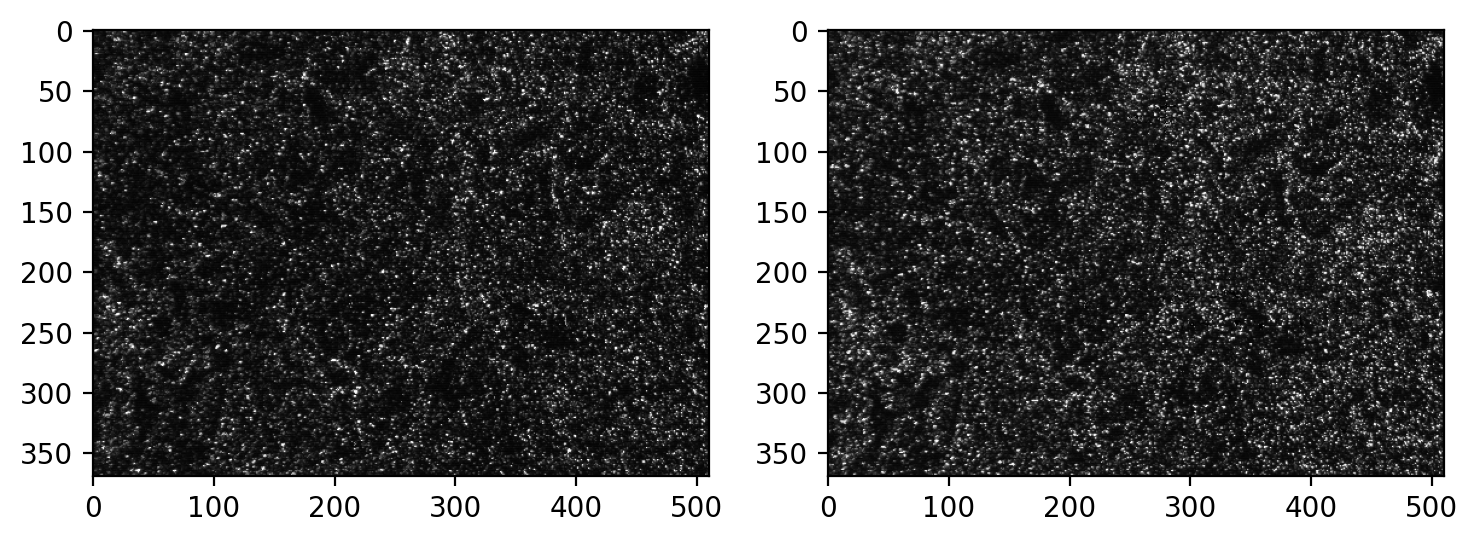

In [9]:
# Show the particle images.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 9), dpi=200, tight_layout=True)
ax1.imshow(frame_a, cmap='gray')
ax2.imshow(frame_b, cmap='gray')
plt.show()

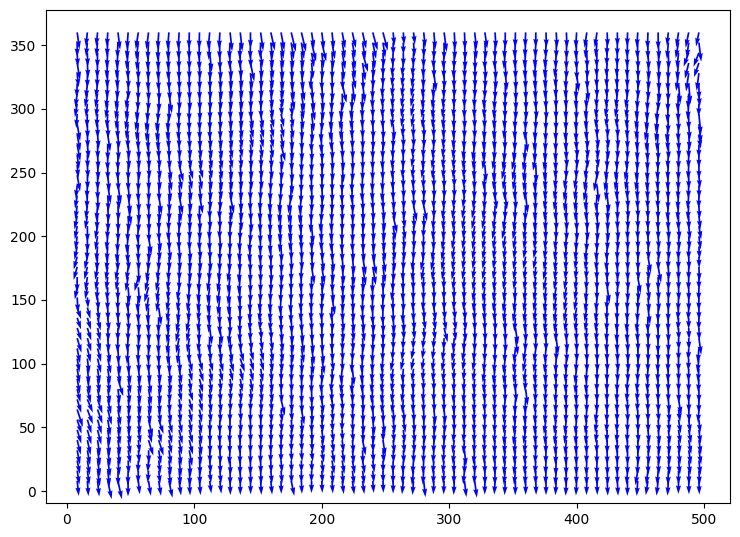

In [10]:
# The results can be visualized using the openpiv.tools module.
fig, ax = plt.subplots(figsize=(7.5, 9), dpi=100, tight_layout=True)
tools.display_vector_field('exp1_001_gpu.txt', ax=ax, scale=250, width=0.0025)
plt.show()